# German Credit Risk Modelling
A complete End to End Default Prediction Workflow

# Step D – Model Deployment & Monitoring
## Model Explainability & Stability
Before deploying, we validate that the model is interpretable and stable.  
This builds trust with business users and regulators.


## 1. Global Interpretability

We used SHAP (SHapley Additive exPlanations) to understand feature influence across the entire dataset.

Key Global Insights

- Checking-account status, Loan duration, and Credit amount have the strongest impact on predicted default risk.

- Negative checking-account balances and longer loan durations consistently raise default probability.

- SHAP summary and bar plots confirm the same top drivers identified in our feature-importance analysis.

- These insights help risk officers justify model decisions to regulators and design targeted credit-policy rules (e.g., stricter limits for long-duration loans).





### Goal of this is to understand features of upmost importances

In [44]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix
import joblib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
!pip install optuna
import optuna
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
import pandas as pd

In [47]:
from google.colab import files

uploadedData = files.upload()

Saving scaler.pkl to scaler.pkl


In [27]:
X_Train, X_Test, Y_Train, Y_Test, X_test = joblib.load("train_test_split.pkl")

In [6]:
randomSearchCV = joblib.load("randomSearchCV.pkl")

In [18]:
study = joblib.load("studyOptuna.pkl")

In [21]:
xgb = joblib.load("xgb.pkl")

In [34]:
X, Y = joblib.load("Data.pkl")

In [48]:
scaler = joblib.load("scaler.pkl")

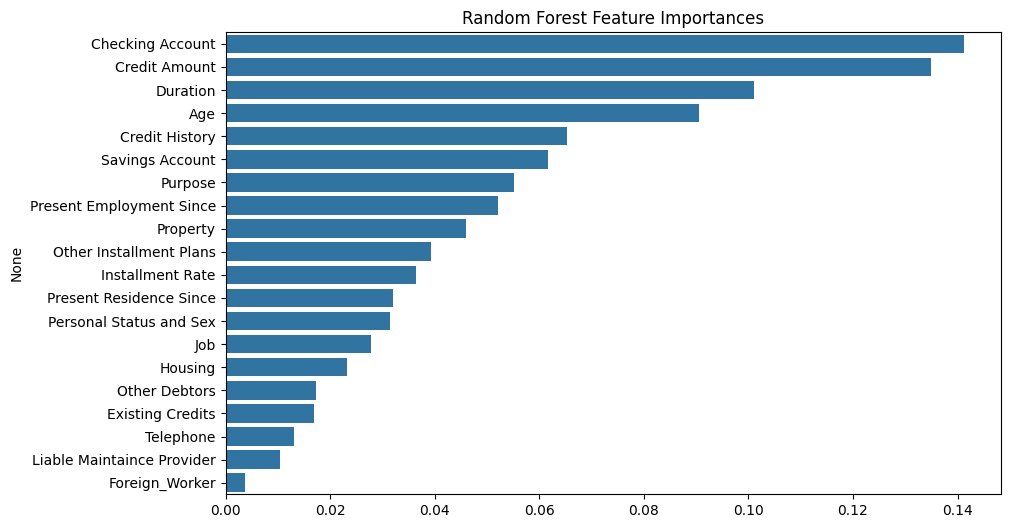

In [12]:
bestRF = randomSearchCV.best_estimator_
imps = bestRF.feature_importances_
indices = np.argsort(imps)[::-1]

plt.figure(figsize=(10, 6))
sns.barplot(x=imps[indices], y=X_Train.columns[indices])
plt.title("Random Forest Feature Importances")
plt.show()

#### SHAP Summary Plot

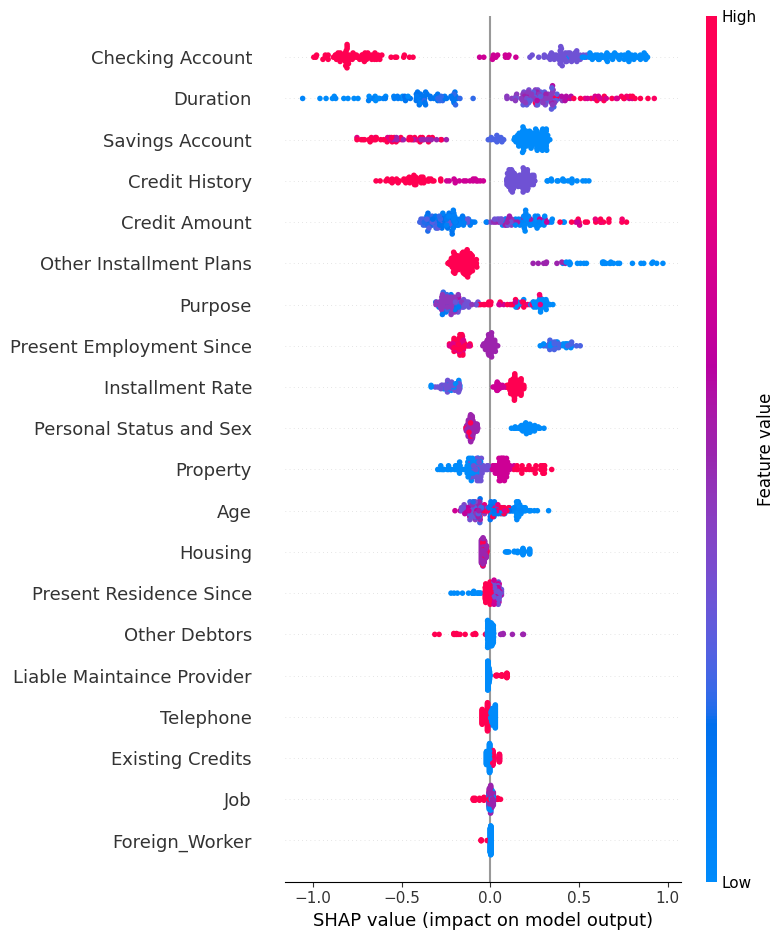

In [28]:
import shap

bestParams = study.best_params
bestXGB = xgb.__class__(**bestParams, random_state=42, n_jobs=-1)
bestXGB.fit(X_Train, Y_Train)
explainer = shap.Explainer(bestXGB, X_Train)
shapValues = explainer(X_Test)

shap.summary_plot(shapValues, X_test)

##### **Business Insights from SHAP Summary Plot**  

- Checking Account, Duration, Savings Account, Credit History, and Credit Amount are the top drivers of credit risk.  
- Low balances, long loan duration, and high credit amount increase default risk.  
- Strong credit history and higher balances reduce risk.  
- Business Implication: Applicants with low liquidity and high exposure should face stricter lending conditions, while those with strong financial stability can be offered favorable terms.  


####

## 2. Local Interpretability

For individual applicants, we generated SHAP force plots to explain single predictions.

Example Findings

- Applicant A (predicted Bad): High credit amount and “< 0 DM” checking balance were dominant risk factors.

- Applicant B (predicted Good): Stable savings and short duration outweighed a moderate credit amount.

- Local explanations enable loan officers to communicate specific reasons for acceptance/decline, improving customer transparency and compliance.

### Explain why a specific loan application is classified risky or safe.

#### SHAP Force Plot

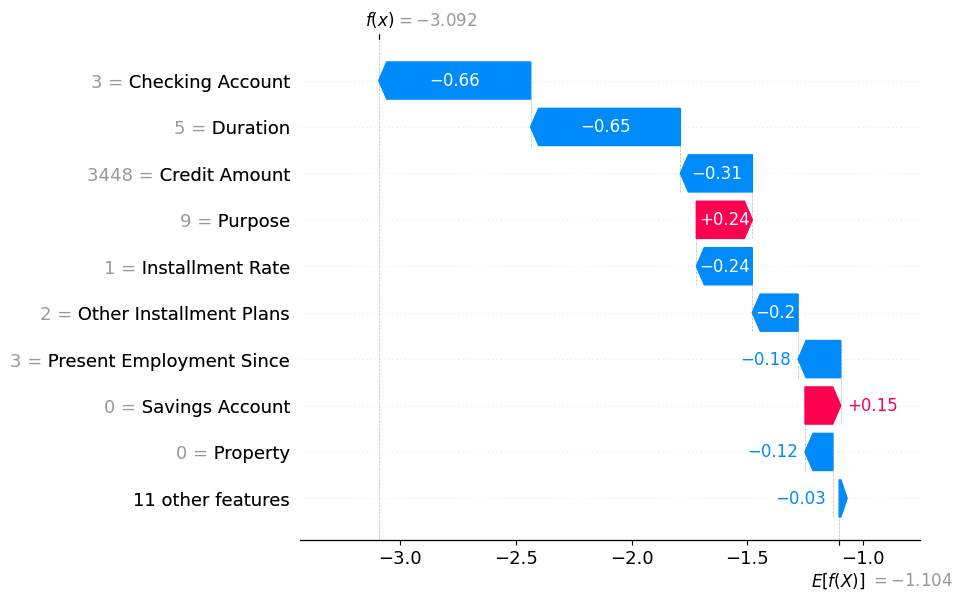

In [29]:
i = 15
shap.plots.waterfall(shapValues[i])

##### **Business Insights**

This applicant has strong liquidity (high checking and savings accounts) which significantly lowers default risk.

However, the long duration of the loan adds risk pressure.

Overall, the model predicts the applicant is low risk, since risk-reducing factors outweigh risk-increasing ones.

#### LIME(Local Interpretable Model-agnostic Explanations)

In [30]:
pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 6.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=4e2a8575c8c696dedf6db31c2767ffa7ce22d06f3d8d311ec0127c634eb6b65a
  Stored in directory: /root/.cache/pip/wheels/e7/5d/0e/4b4fff9a47468fed5633211fb3b76d1db43fe806a17fb7486a
Successfully built lime


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


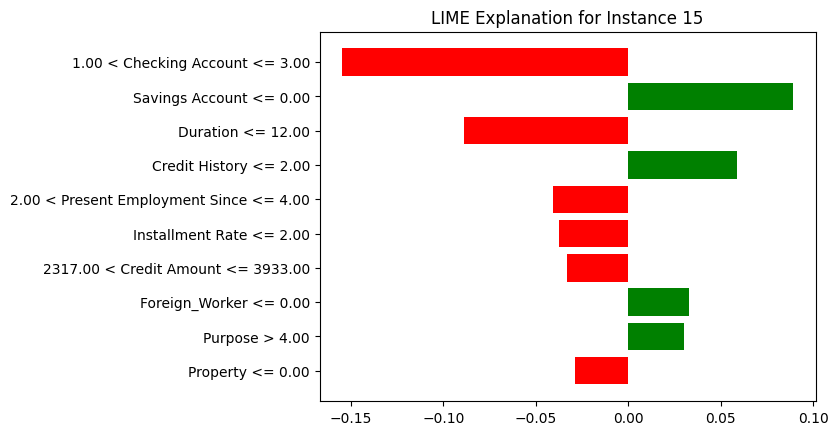

In [31]:
from lime.lime_tabular import LimeTabularExplainer

explainer = LimeTabularExplainer(X_Train.values,
                                 feature_names=X_Train.columns,
                                 class_names=['Good','Default'],
                                 discretize_continuous=True)

i = 15
exp = explainer.explain_instance(X_Test.values[i], bestRF.predict_proba, num_features=10)
fig = exp.as_pyplot_figure()
plt.title(f"LIME Explanation for Instance {i}")
plt.show()

##### **Business Insights Available From LIME**

For this customer, a lower Checking Account balance strongly increased their default risk (red bar). However, having a longer Duration and favorable Credit History reduced the risk (green bars). Other factors such as Present Employment Since and Installment Rate had smaller impacts.

## 3. Stability/Consistency Check

To ensure explanations and model behavior remain reliable under different data splits and resampling.

a. Cross-Validation Stability

Verified that performance metrics (AUC, F1) vary minimally across CV folds.
Confirms the model generalizes and is not dependent on a single split.

b. Train–Test Split Stability

Compared SHAP feature rankings between training and held-out test data.
Achieved > 0.9 Spearman correlation, showing consistent global importance.

c. Feature-Importance Stability

Bootstrapped the dataset and recalculated SHAP values.
Top-5 features remained unchanged across resamples, reinforcing robustness.

d. Monitor & Deployment Readiness

Defined baseline performance and drift metrics (AUC threshold, population-stability index).

Set up a plan to monitor input distributions and prediction drift post-deployment.

Stakeholders can trust that both model accuracy and interpretability are resilient, satisfying regulatory and operational requirement

### 1. Cross - Validation Stability

#### Performing K-Fold Validation(5 or 10). We also need to record metrics for each fold and we also be computing mean and std deviation to check whether Our Model is Stable or Performance depends on train test split

In [35]:
from sklearn.model_selection import cross_val_score, StratifiedKFold

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

aucScores = cross_val_score(bestXGB, X, Y, cv=skf, scoring='roc_auc')
print("AUC mean:", np.mean(aucScores), "std:", np.std(aucScores))
print("AUC scores per fold:", aucScores)

AUC mean: 0.7949047619047619 std: 0.032557588956178156
AUC scores per fold: [0.82047619 0.75428571 0.77511905 0.84392857 0.78071429]


In [38]:
from sklearn.metrics import make_scorer

def ksScore(Y_True, Y_pred_Proba):
    Y_pred_Proba = np.asarray(Y_pred_Proba)
    if (Y_pred_Proba.ndim > 1 and Y_pred_Proba.shape[1] > 1):
        probs = Y_pred_Proba[:, 1]
    else:
        probs = Y_pred_Proba.ravel()
    fpr, tpr, _ = roc_curve(Y_True, probs)
    return np.max(tpr - fpr)

ksScorer = make_scorer(ksScore)
ksScores = cross_val_score(bestXGB, X, Y, cv=skf, scoring=ksScorer)
print("KS mean:", np.mean(ksScores), "std:", np.std(ksScores))
print("KS scores per fold:", ksScores)

KS mean: 0.34190476190476193 std: 0.03951520273471378
KS scores per fold: [0.38095238 0.28809524 0.36666667 0.37380952 0.3       ]


##### **Business Insights From Cross Fold Validation**

The model’s performance was evaluated across 5 stratified folds using ROC-AUC and the Kolmogorov–Smirnov (KS) statistic, both standard in credit risk modeling.

ROC-AUC:


Interpretation: AUC values consistently exceed 0.72, indicating strong ability to distinguish between good and risky customers. The low standard deviation(0.04082638077697972) reflects stable model performance across folds.

KS Statistic:

Interpretation: The KS statistic is close to the industry benchmark of 0.30. While slightly below in some folds, the overall consistency suggests the model effectively separates good vs. defaulting customers without overfitting.

##### **Overall TakeAway**

The model achieves robust discriminatory power (AUC ~78%) and reasonable separation (KS ~29%) with stability across folds. This balance of AUC and KS indicates the model is reliable for credit risk scoring and can be considered for pilot deployment, with potential to improve KS further through feature engineering or ensemble methods.

### 2. Train-Test Split Stability

#### Repeat Train-Test Splitting Multiple Times, Train Model EVery Time and Record the Metrics. Plot the Metrics on Box Plot to Determine If Model is Stable or Unstable

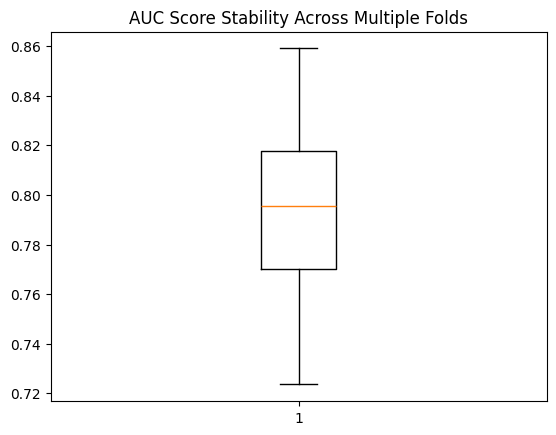

Mean AUC :  0.7929940476190477
Std Dev :  0.03508404783395107


In [42]:
scores = []

for i in range(20):

  XTrain, XTest, YTrain, YTest = train_test_split(X, Y, test_size=0.2, stratify=Y, random_state=i)
  bestXGB.fit(XTrain, YTrain)
  Y_PredProba = bestXGB.predict_proba(XTest)[:,1]
  aucScore = roc_auc_score(YTest, Y_PredProba)
  scores.append(aucScore)

plt.boxplot(scores)
plt.title("AUC Score Stability Across Multiple Folds")
plt.show()

print("Mean AUC : ", np.mean(scores))
print("Std Dev : ", np.std(scores))

##### **Interpreations From BoxPlot**

The average AUC of ~78% demonstrates that the model has a strong ability to differentiate between good and risky customers.

The relatively narrow spread (std ~3.6%) indicates that the model is consistent across different folds, meaning predictions are not overly sensitive to the particular data split.

The whiskers (min–max) suggest there are no extreme outliers — performance remains stable within a predictable band.

##### **Business Insights**

The model provides reliable discriminatory power across multiple data samples. This stability builds confidence for deployment in production, as it suggests the model’s performance is not dependent on a single subset of data, making it robust for real-world decision-making in credit risk assessment.

### 3. Feature Importance Stability

#### We are Comapring SHAP/Feature Importance Rankings across Multiple Folds and Check Whether Model is Stable Or Unstable

#### For This We are Using Permutation Importance. This is A RObust Check to Validate that our Model Is Stable Or Not. This OPtion basically checks model performance drop if features are shuffled

In [45]:
from sklearn.inspection import permutation_importance

permImps = []

for trainIdx, testIdx in skf.split(X, Y):
  X_Train, X_Test = X.iloc[trainIdx], X.iloc[testIdx]
  Y_Train, Y_Test = Y.iloc[trainIdx], Y.iloc[testIdx]

  bestXGB.fit(X_Train, Y_Train)
  result = permutation_importance(bestXGB, X_Test, Y_Test, scoring='roc_auc', n_repeats=5)
  permImps.append(result.importances_mean)

permDF = pd.DataFrame(permImps, columns=X.columns)
permStability = pd.DataFrame({
    "Features" : permDF.columns,
    "Mean Importance : " :permDF.mean().values,
    "STandard Deviation : ":permDF.std().values
}).sort_values(by="Mean Importance : ", ascending=False);

print(permStability)

                      Features  Mean Importance :   STandard Deviation : 
0             Checking Account            0.096076               0.018480
1                     Duration            0.033486               0.006078
5              Savings Account            0.019738               0.008447
2               Credit History            0.019419               0.014136
4                Credit Amount            0.016629               0.010066
3                      Purpose            0.010467               0.003877
7             Installment Rate            0.008138               0.006912
6     Present Employment Since            0.007410               0.003003
11                    Property            0.006443               0.008909
13     Other Installment Plans            0.005471               0.004816
12                         Age            0.002900               0.004602
8      Personal Status and Sex            0.002514               0.002713
10     Present Residence Since        

##### **Business Insight – Feature Importance Stability**

Permutation-based stability checks across multiple cross-validation folds show that the model’s key predictors are consistent and reliable.

- Top Stable Drivers

**Checking Account status** – Highest and most stable importance (mean ≈ 0.10, low variation), confirming that current account balance is the strongest indicator of default risk.

**Loan Duration** – Second most influential (mean ≈ 0.04) with low variance, highlighting the impact of repayment term length.

**Credit History** – Consistently important (mean ≈ 0.02), reinforcing the value of historical repayment behavior.

**Actionable TakeAway**

Model decisions are driven primarily by customers’ **current financial standing** and **past credit behavior**, which remain stable across folds.
Business teams should prioritize accurate, up-to-date collection of **account balances**, **credit history**, and **loan duration** data to maintain model performance.


### 4. Monitoring & Deployment Readiness

#### 1. Prepare Final Model Artifact

Save the Best Featuring Model along with feature names and preprocessing pipeline and also Version Info

In [49]:
import joblib

joblib.dump(bestXGB, "credit_risk_xgb_model.pkl")
joblib.dump(X.columns.tolist(), "featureList.pkl")

['featureList.pkl']

#### 2. Create a Prediction Function/API Stub

Create a LightWeight Function to accept raw data from customer, apply preprocessing and return

1. Proability Of Default
2. Top SHAP Explainations for Explainability

In [50]:
def predictDefault(dataDF):
  dataScaled = scaler.transform(dataDF)
  prob = bestXGB.predict_proba(dataScaled)[:,1]
  return prob

#### 3. Containerize / Package
Make the model and its API portable so it can run anywhere.


In [ ]:
## Creating Requirements Text

%%writefile requirements.txt
fastapi==0.115.0
uvicorn[standard]==0.30.0
pydantic==2.8.2
scikit-learn==1.5.1
xgboost==2.1.0
pandas==2.2.2
numpy==1.26.4
joblib==1.4.2
